# How to Work with Huge Datasets

## Ross Woleben

This notebook is a supplement to the [How to Work with Huge Datasets](https://www.rosswoleben.com/projects/big-data) post on my website. It discusses some file and data type optimizations, chunking, and parallel computing.

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import gc
import multiprocessing as mp

In [2]:
# Data from https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
file_path = "data/2019-Nov.csv"
# os.stat returns a dictionary of file attributes; st_size is the file size in bytes. 
# Dividing byte size by 10^9 will give us size in gigabytes 
os.stat(file_path).st_size / 10 ** 9

9.006762395

We can see that this CSV file takes up 9 gigabytes of storage; reading the entire dataset into memory may be possible, but will take up a lot of resources. Let's use a few strategies to make huge files like this much easier to work with.
<br><br>
Note: For this notebook, I'll be demonstrating these strategies with Pandas. Pandas may not be the best data structure for a huge dataset, but it still shows the value of each strategy.

## Explicit Data Typing

When a CSV is read into a data structure like Pandas, the data types for each column are inferred, leading for the possibility of using a lot of unneccesary memory usage.
<br>
<br>
For example, by default Pandas reads in all strings as a numpy "object" datatype, which requires a relatively large amount of memory. If these strings can take on a a fixed set of possible values, it makes a lot of sense to change the column to a "category" datatype. This concept extends to numberic columns too. If you have a column with integers that are all less than 4,294,967,295 (2^32), you'll want to use a 32-bit integer instead of a 64-bit integer.


In [3]:
# lets load in a fraction of data (around 1/7th of the rows) to see what kind of data types we're working with
rows = 10_000_000
df = pd.read_csv(file_path, nrows = rows)
df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [4]:
# use dataframe's .dtypes attribute to check the datatypes of each column
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

In [5]:
# Use .info() to check the amount of memory being used
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.6 GB


Note: We can see that loading in ~$\frac{1}{7}$th of the data is using 3.6 gigabytes of memory. This is much larger than the logical 1.3 gigabytes ($\frac{1}{7}$th of 9 gigabytes) because a Pandas dataframe object is dynamic and meant to be manipulated. As a result, storing the data in this object and obtaining the access to many different pandas methods and functions consumes more memory than just the raw memory required to load the data into RAM.

In [6]:
# Let's check and see if we can reduce the size of these integer columns
# 4,294,967,295 is the maximum value for a 32-bit integer; 
# if True, we can replace the int64 datatype with int32 
print(4_294_967_295 > np.max(df['product_id']))
print(4_294_967_295 > np.max(df['category_id']))
print(4_294_967_295 > np.max(df['user_id']))

True
False
True


In [7]:
# Here are the datatypes I'm redefining for this dataset
# Since event_type, category_code, and brand take on a fixed set of string values, 
# converting them to 'category' dtype saves memory usage
df_dtypes = {'event_type': 'category', 'product_id': np.int32, 'category_code': 'category',
             'brand': 'category', 'price': np.float64, 'user_id': np.int32}
df_with_dtypes = pd.read_csv(file_path, nrows = rows, dtype = df_dtypes)
df_with_dtypes.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [8]:
df_with_dtypes.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
 #   Column         Dtype   
---  ------         -----   
 0   event_time     object  
 1   event_type     category
 2   product_id     int32   
 3   category_id    int64   
 4   category_code  category
 5   brand          category
 6   price          float64 
 7   user_id        int32   
 8   user_session   object  
dtypes: category(3), float64(1), int32(2), int64(1), object(2)
memory usage: 1.9 GB


In this example, changing our datatypes alone saved nearly 50% of the memory usage (3.6 GB -> 1.9 GB). Depending on the types of data, this process can save an even larger percentage of memory, making it easier to perform computations in the data processing stage. 

## File Types

CSV files are great if the data is meant to be opened in a program like Excel, but really struggles with huge amounts of data. This is primarily because there is no native compression built into CSV files and no metadata to signal a column's datatype. CSV file I/O is also relatively slow, meaning that it takes a long time to actually read the data into Python and a long time to write any changes back to storage. Luckily, there are several alternatives to CSVs that make working with huge data files much more efficient in storage, memory, and I/O speeds.
<br>
<br>
You can actually define the datatypes before reading in a CSV file. This won't improve the speed in which it's read in, but will decrease the amount of memory it uses. However, once the data is written to storage as a CSV, it "forgets" the explicit typing and will revert back to an unoptimized state when read in.

In [9]:
df = pd.read_csv(file_path, nrows = rows)
df.info(verbose = False, memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Columns: 9 entries, event_time to user_session
dtypes: float64(1), int64(3), object(5)
memory usage: 3.6 GB


In [10]:
df = pd.read_csv(file_path, nrows = rows, dtype = df_dtypes)
df.info(verbose = False, memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Columns: 9 entries, event_time to user_session
dtypes: category(3), float64(1), int32(2), int64(1), object(2)
memory usage: 1.9 GB


In [11]:
# Clear up some memory we've used for this demonstration
del df

Now let's investigate I/O speeds and file sizes for multiple types of files. <br>
Note: these speeds are subject to your computer hardware and the relative file type performance depends on the underlying dataset. You may need to experiment with each file type to see which is best for your own project. 

### .csv

Check how fast it is to write the Pandas dataframe above to storage

In [12]:
%%timeit
df_with_dtypes.to_csv('file.csv', index = False)

41.3 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check how fast it is to read the Pandas dataframe into RAM

In [13]:
%%timeit
df_csv = pd.read_csv('file.csv')

12.1 s ± 97.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check the file size in storage

In [14]:
# 1.04 gigabytes
os.stat('file.csv').st_size / 10 ** 9

1.341149223

### .pickle

In [15]:
%%timeit
df_with_dtypes.to_pickle('file.pickle')

2.08 s ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
df_pickle = pd.read_pickle('file.pickle')

1.14 s ± 35.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
# 473 Megabytes
os.stat('file.pickle').st_size / 10 ** 9

0.473383414

### .parquet

In [18]:
%%timeit
df_with_dtypes.to_parquet('file.parquet')

5.03 s ± 87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
df_parquet = pd.read_parquet('file.parquet')

2.81 s ± 45.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
# 385 Megabytes
os.stat('file.parquet').st_size / 10 ** 9

0.384933645

### .feather

In [21]:
%%timeit
df_with_dtypes.to_feather('file.feather')

2.21 s ± 43.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
df_feather = pd.read_feather('file.feather')

1.96 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
# 537 MB
os.stat('file.feather').st_size / 10 ** 9

0.53724645

In [24]:
gc.collect()

6

We can see that CSV is much slower to read and write and occupies more space in storage than Pickle, Parquet, or Feather files. The type of problem you are trying to solve may likely determine what file type you choose to work with.

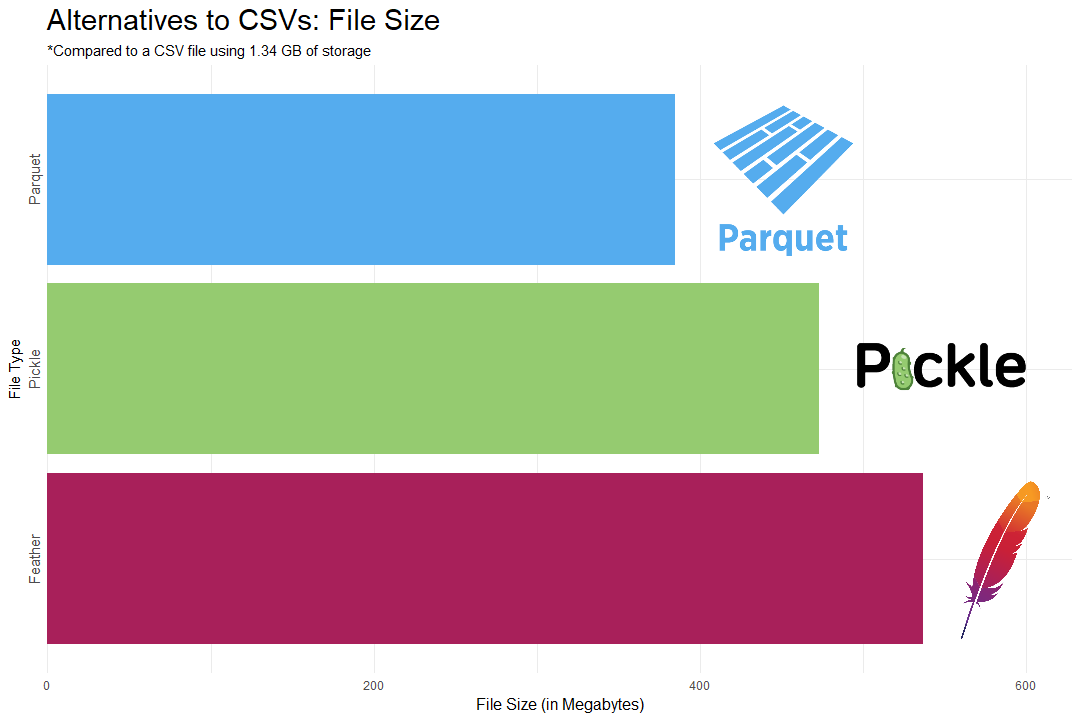

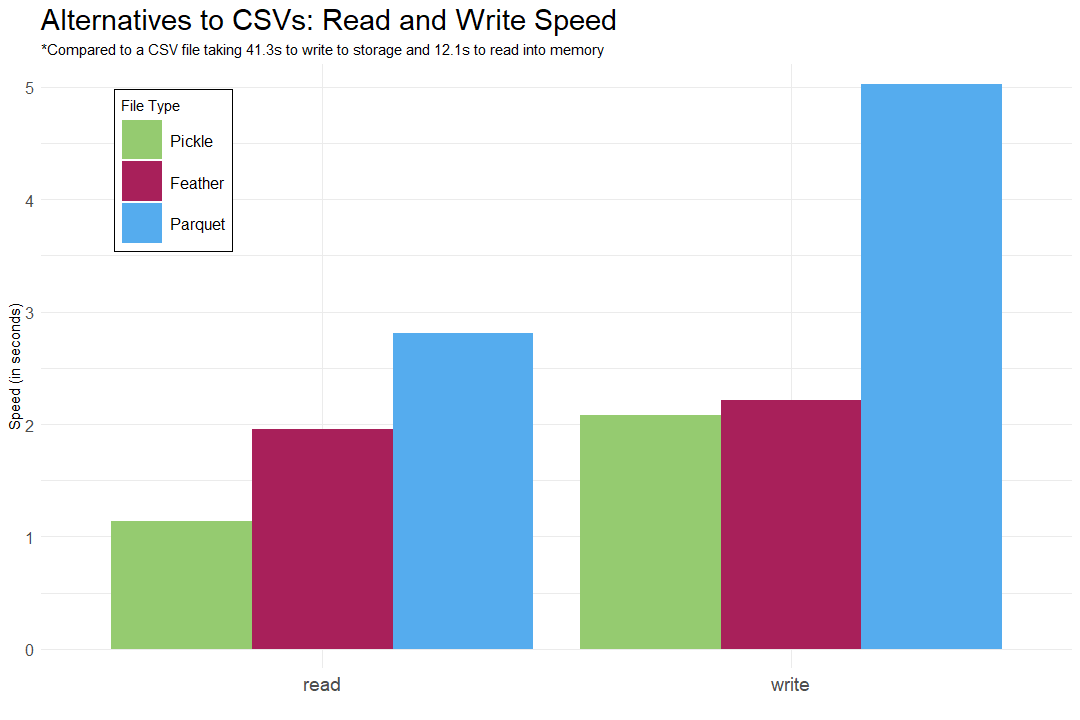

## Dividing Data into Chunks

Depending on the problem you are trying to solve, you can save memory usage by loading in portions of a dataset at a time or simply ignoring irrelevant columns. Chunking refers to loading in chunks of the data, and performing some type of computation on each chunk such that you can get the value or an approximation of the value you would get if you loaded in the entire dataset at once.

In [25]:
df = pd.read_csv(file_path, nrows = rows, dtype = df_dtypes)

In [26]:
def get_rowcount_large_file(filepath):
    with open(file_path) as f:
        return sum(1 for line in f)

In [27]:
get_rowcount_large_file(file_path)

67501980

In [28]:
chunk_number = 1
sum_cols = 0
# there are 67,501,980 rows in this dataset, so we can divide it into ~68 chunks of 1,000,000 rows
for chunk in pd.read_csv(file_path, chunksize=1_000_000):
    ## PERFORM SOME COMPUTATION HERE
    # This example finds the sum of all the values in the product_id, category_id, price, and user_id columns
    # This computation isn't particularly useful, but shows the potential benefits chunking can offer
    sum_cols = np.sum([chunk['product_id'], chunk['category_id'], chunk['price'], chunk['user_id']]) + sum_cols
    
    # Print sum after ever 10 chunks
    if chunk_number % 10 == 0:
        print(f"Sum after {chunk_number} chunks: {sum_cols}")
    
    chunk_number+=1

print(f"Sum after {chunk_number} chunks: {sum_cols}")

Sum after 10 chunks: 2.0578281908942404e+25
Sum after 20 chunks: 4.11567463288836e+25
Sum after 30 chunks: 6.173145752110703e+25
Sum after 40 chunks: 8.231172230191228e+25
Sum after 50 chunks: 1.0288828450126491e+26
Sum after 60 chunks: 1.234698523126513e+26
Sum after 69 chunks: 1.3891216360838123e+26


In [29]:
gc.collect()

0

## Parallel Computing

As I mentioned in the main post, you can parallize your code to make processes more efficient. Most modern CPUs have upwards of eight cores, which are small processing units that can handle separate tasks independently, allowing for you to execute your code in parallel. GPUs have thousands of these cores, making them excellent at performing computations in parallel. 

Usually if a specific task is known to greatly benefit from being computed in parallel, there will most likely be a Python package that does back-end optimizations to make use of multiple cores of your CPU or your GPU. In fact, deep learning libraries like TensorFlow and PyTorch can take full advantage of the “embarrassingly parallel” nature of neural network training and direct computations to your GPU instead of CPU. That being said, you still have the ability to manually parallize any of your code, as long as it makes sense in a parallel computing context.

Consider an example where you are trying to calculate the mean of 100 numbers. If you were to calculate this normally, you would just add up all 100 numbers then divide by 100. You can compute this mean in parallel by dividing the dataset into 5 subsets of 20, take the mean of each of those subsets, and average those means to arrive at the same answer. When you only have 100 numbers, you won't be saving that much time, however, if you have 100 billion numbers, computing in parallel will save a lot of time. 

<img src="Parallel_Computing_Example.png" alt="Drawing" style="height: 600px"/>

In [30]:
# Replicating the picture above in numpy
np.random.seed(0)
data = np.random.randint(10, size = (5, 10))
data

array([[5, 0, 3, 3, 7, 9, 3, 5, 2, 4],
       [7, 6, 8, 8, 1, 6, 7, 7, 8, 1],
       [5, 9, 8, 9, 4, 3, 0, 3, 5, 0],
       [2, 3, 8, 1, 3, 3, 3, 7, 0, 1],
       [9, 9, 0, 4, 7, 3, 2, 7, 2, 0]])

In [31]:
parallel_means = np.mean(data, axis = 1)
parallel_means

array([4.1, 5.9, 4.6, 3.1, 4.3])

In [32]:
traditional_mean = np.mean(data)
traditional_mean

4.4

In [33]:
# We can see that the mean computations are the same
np.mean(parallel_means) == traditional_mean

True